# Higgs Boson Machine Learning Challenge

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Loading the full Set:

In [2]:
data_full = pd.read_csv('atlas-higgs-challenge-2014-v2.csv')
data_full.head(10)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,b,t,6.245333
5,100005,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,...,-2.412,-0.653,56.165,0.224,3.106,193.660,0.025434,b,t,0.083414
6,100006,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,...,0.864,1.450,56.867,0.131,-2.767,179.877,0.000814,s,t,0.002653
7,100007,154.916,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,1.526,...,-0.715,-1.724,-999.000,-999.000,-999.000,30.638,0.005721,s,t,0.018636
8,100008,105.594,50.559,100.989,4.288,-999.000,-999.000,-999.000,2.904,4.288,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.614803,b,t,5.296003
9,100009,128.053,88.941,69.272,193.392,-999.000,-999.000,-999.000,1.609,28.859,...,-2.767,-2.514,-999.000,-999.000,-999.000,167.735,0.000461,s,t,0.001502


### Split the data
This Set contains the following subsets, indexed by the `KaggleSet`variable:  
+ `t`: Training,
+ `b`: Public Leaderboard,
+ `v`: Privateleaderboard,
+ `u`: Unused.

In [4]:
print('Total number of events: ', len(data_full), '\n')
for KaggleSetID in ['t', 'b', 'v', 'u']:
    print('Number of events in the {} KaggleSet: {}'
          .format(KaggleSetID, len(data_full['KaggleSet'][data_full['KaggleSet']==KaggleSetID])))

Total number of events:  818238 

Number of events in the t KaggleSet: 250000
Number of events in the b KaggleSet: 100000
Number of events in the v KaggleSet: 450000
Number of events in the u KaggleSet: 18238


### I should here probably only use the `t` set for the training and the `b` set for validation. At the very end, I can get our score from the private leaderboard `v` set  (?!?!)

In [6]:
train_data = data_full[data_full['KaggleSet']=='t']
validation_data = data_full[data_full['KaggleSet']=='b']

In [84]:
y_train = pd.get_dummies(train_data['Label']).values.astype(float) #signal = [0,1], background = [1,0]
y_val = pd.get_dummies(validation_data['Label']).values.astype(float)

In [9]:
len(train_data), len(validation_data)

(250000, 100000)

Of course, there will be strong correlations between the derived variables `DER`and the primitive variables`PRI`, which is shown in the following:

In [5]:
correlations = train_data.corr()

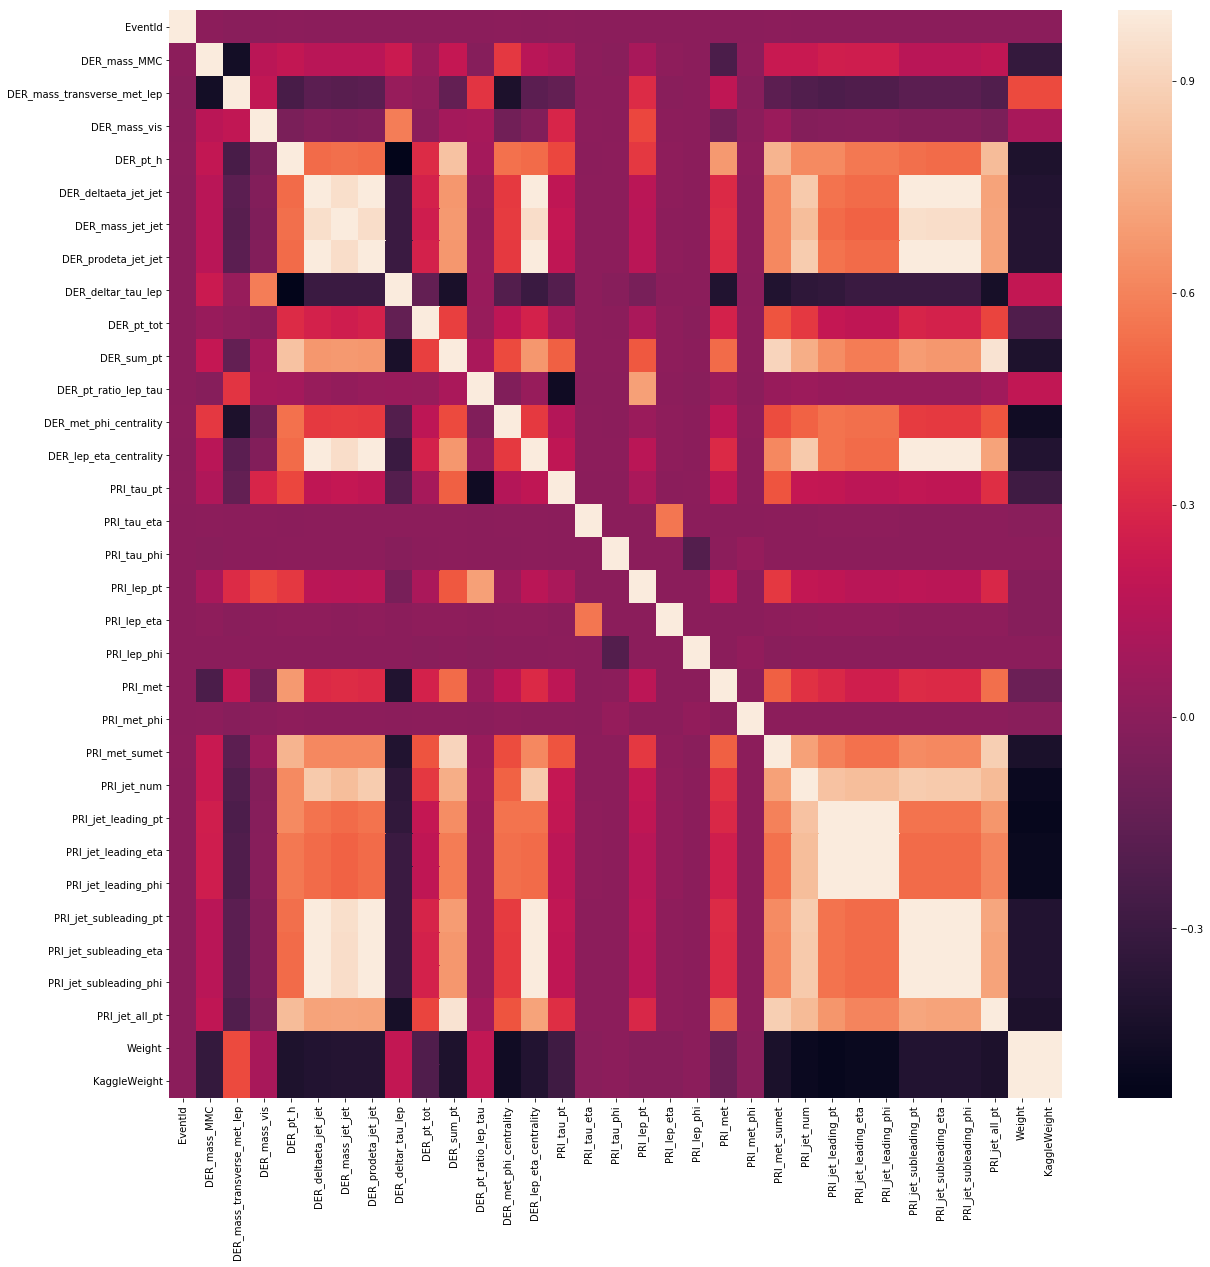

In [35]:
import seaborn as sns

plt.figure(figsize=(20,20))
sns.heatmap(correlations)

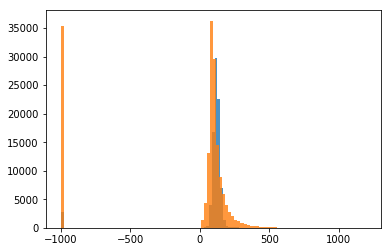

In [10]:
plt.hist(train_data['DER_mass_MMC'][train_data['Label']=='s'], bins=100, alpha=.8)
plt.hist(train_data['DER_mass_MMC'][train_data['Label']=='b'], bins=100, alpha=.8)
plt.show()

### I will now try a simple DNN on the full Set:

In [81]:
X = train_data.iloc[:,1:-4]
X_val = validation_data.iloc[:,1:-4]
X.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [18]:
model_2 = Sequential()
model_2.add(Dense(128, input_dim=30))
model_2.add(Activation('relu'))
model_2.add(Dense(64))
model_2.add(Activation('relu'))
model_2.add(Dense(32))
model_2.add(Activation('relu'))
model_2.add(Dense(16))
model_2.add(Activation('relu'))
model_2.add(Dense(8))
model_2.add(Activation('relu'))
model_2.add(Dense(4))
model_2.add(Activation('relu'))
model_2.add(Dense(2))
model_2.add(Activation('softmax'))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               3968      
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_9 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_10 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)               

In [19]:
model_2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
minmax_X = MinMaxScaler(feature_range=(-1,1))
minmax_X.fit(X)
X_minmax = minmax_X.transform(X)

C:\Users\flori\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [23]:
model_2.fit(X, y_train, epochs=20, batch_size=1024)

Epoch 1/20
250000/250000 [==============================] - 2s 9us/step - loss: 0.4089 - accuracy: 0.8126
Epoch 2/20
250000/250000 [==============================] - 3s 10us/step - loss: 0.4088 - accuracy: 0.8128
Epoch 3/20
250000/250000 [==============================] - 2s 9us/step - loss: 0.4074 - accuracy: 0.8132
Epoch 4/20
250000/250000 [==============================] - 2s 9us/step - loss: 0.4048 - accuracy: 0.8149
Epoch 5/20
250000/250000 [==============================] - 2s 9us/step - loss: 0.4045 - accuracy: 0.8148
Epoch 6/20
250000/250000 [==============================] - 2s 8us/step - loss: 0.4031 - accuracy: 0.8153
Epoch 7/20
250000/250000 [==============================] - 2s 9us/step - loss: 0.4021 - accuracy: 0.8162
Epoch 8/20
250000/250000 [==============================] - 2s 9us/step - loss: 0.4009 - accuracy: 0.8168
Epoch 9/20
250000/250000 [==============================] - 2s 9us/step - loss: 0.4001 - accuracy: 0.8171
Epoch 10/20
250000/250000 [==================

In [29]:
model_2.fit(X_minmax, y_train, epochs=20, batch_size=1024)

Epoch 1/20
250000/250000 [==============================] - 2s 10us/step - loss: 0.5671 - accuracy: 0.6934
Epoch 2/20
250000/250000 [==============================] - 2s 9us/step - loss: 0.5193 - accuracy: 0.7329
Epoch 3/20
250000/250000 [==============================] - 2s 10us/step - loss: 0.4989 - accuracy: 0.7472
Epoch 4/20
250000/250000 [==============================] - 3s 13us/step - loss: 0.4835 - accuracy: 0.7584
Epoch 5/20
250000/250000 [==============================] - 3s 11us/step - loss: 0.4737 - accuracy: 0.7647 0s - loss: 0.4744 - accuracy
Epoch 6/20
250000/250000 [==============================] - 3s 11us/step - loss: 0.4627 - accuracy: 0.7735
Epoch 7/20
250000/250000 [==============================] - 3s 10us/step - loss: 0.4546 - accuracy: 0.7797
Epoch 8/20
250000/250000 [==============================] - 2s 10us/step - loss: 0.4469 - accuracy: 0.7853
Epoch 9/20
250000/250000 [==============================] - 3s 11us/step - loss: 0.4404 - accuracy: 0.7897
Epoch 10/

### Idea: I think I should separate the data set according to the number of jets, there are 8 `PRI` variables about the jets?!   Or try to separate the VBF and the other one?!

I will just shortly try only using the events without jets:
the following variables do not make sense here: 
+ DER_deltaeta_jet_jet
+ DER_mass_jet_jet
+ DER_prodeta_jet_jet
+ DER_lep_eta_centrality
+ PRI_jet_num
+ PRI_jet_leading_pt
+ PRI_jet_leading_eta 
+ PRI_jet_leading_phi
+ PRI_jet_subleading_pt
+ PRI_jet_subleading_eta
+ PRI_jet_subleading_phi
+ PRI_jet_all_pt

In [30]:
X_0jets = X[ X['PRI_jet_num']==0 ].drop(['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 
                                         'DER_lep_eta_centrality', 'PRI_jet_num', 'PRI_jet_leading_pt', 
                                         'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 
                                         'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt'], axis =1)
X_0jets.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet
count,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.000000,99913.00000
mean,-172.077816,58.786239,81.870309,13.823867,2.664961,13.823867,76.377011,1.392763,-0.910077,34.012723,-0.024858,-0.015657,42.364287,-0.052311,0.042352,31.536761,-0.024443,125.86081
std,494.022274,32.003551,38.043669,16.674707,0.693295,16.674707,23.561057,0.581596,0.936707,15.229541,1.233430,1.817351,14.585979,1.310855,1.817844,20.294541,1.811006,53.08660
min,-999.000000,0.002000,7.120000,0.000000,0.277000,0.000000,46.104000,0.127000,-1.414000,20.000000,-2.499000,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,13.67800
25%,-999.000000,35.062000,60.947000,2.275000,2.338000,2.275000,61.297000,0.968000,-1.404000,23.655000,-0.960000,-1.586000,31.863000,-1.121000,-1.526000,18.001000,-1.583000,87.95100
50%,96.528000,62.144000,75.533000,6.677000,2.822000,6.677000,71.586000,1.318000,-1.364000,29.329000,-0.043000,-0.049000,38.969000,-0.104000,0.085000,29.538000,-0.051000,119.47900
75%,126.793000,79.650000,94.135000,24.202000,3.095000,24.202000,85.242000,1.728000,-1.123000,39.808000,0.900000,1.556000,49.007000,0.989000,1.621000,42.273000,1.546000,156.41800
max,863.647000,570.115000,1349.351000,2834.999000,5.684000,2834.999000,1324.678000,10.571000,1.414000,764.408000,2.494000,3.142000,560.271000,2.503000,3.142000,2842.617000,3.142000,1391.52900


In [31]:
y_train_0jets = y_train[ X['PRI_jet_num']==0 ]
len(y_train_0jets)

99913

In [32]:
minmax_0jets = MinMaxScaler(feature_range=(-1,1))
minmax_0jets.fit(X_0jets)
X_0jets_minmax = minmax_0jets.transform(X_0jets)

In [33]:
model_2 = Sequential()
model_2.add(Dense(128, input_dim=18))
model_2.add(Activation('relu'))
model_2.add(Dense(64))
model_2.add(Activation('relu'))
model_2.add(Dense(32))
model_2.add(Activation('relu'))
model_2.add(Dense(16))
model_2.add(Activation('relu'))
model_2.add(Dense(8))
model_2.add(Activation('relu'))
model_2.add(Dense(4))
model_2.add(Activation('relu'))
model_2.add(Dense(2))
model_2.add(Activation('softmax'))

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               2432      
_________________________________________________________________
activation_15 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_16 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_17 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)               

In [34]:
model_2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
model_2.fit(X_0jets_minmax, y_train_0jets, epochs=20, batch_size=1024)

Epoch 1/20
99913/99913 [==============================] - 1s 10us/step - loss: 0.5097 - accuracy: 0.7450
Epoch 2/20
99913/99913 [==============================] - 1s 8us/step - loss: 0.4451 - accuracy: 0.7871
Epoch 3/20
99913/99913 [==============================] - 1s 8us/step - loss: 0.4133 - accuracy: 0.8118
Epoch 4/20
99913/99913 [==============================] - 1s 8us/step - loss: 0.4025 - accuracy: 0.8158
Epoch 5/20
99913/99913 [==============================] - 1s 8us/step - loss: 0.3954 - accuracy: 0.8171
Epoch 6/20
99913/99913 [==============================] - 1s 9us/step - loss: 0.3887 - accuracy: 0.8210: 0s - loss:
Epoch 7/20
99913/99913 [==============================] - 1s 10us/step - loss: 0.3857 - accuracy: 0.8220
Epoch 8/20
99913/99913 [==============================] - 1s 9us/step - loss: 0.3827 - accuracy: 0.8231
Epoch 9/20
99913/99913 [==============================] - 1s 11us/step - loss: 0.3803 - accuracy: 0.8247 0s - loss: 0.3801 - accuracy: 0.
Epoch 10/20
9991

At least a slightly higher accuracy...

In [36]:
X_2jets = X[ X['PRI_jet_num']>=2 ]
len(X_2jets)

72543

In [83]:
X_val_2jets = X_val[ X_val['PRI_jet_num']>=2 ]
len(X_val_2jets)

29046

In [37]:
X_2jets.head(10)

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
5,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,278.876,...,2.237,282.849,3,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660
6,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,305.967,...,-1.443,294.074,2,123.010,0.864,1.450,56.867,0.131,-2.767,179.877
11,114.744,10.286,75.712,30.816,2.563,252.599,-1.401,2.888,36.745,239.804,...,2.148,290.547,3,76.773,-0.790,0.303,56.876,1.773,-2.079,165.640
23,141.481,0.736,111.581,174.075,1.955,364.344,-0.923,1.335,6.663,440.859,...,-0.973,454.785,2,195.533,1.156,1.416,82.477,-0.798,-2.785,278.009
27,111.271,27.180,70.642,144.766,4.936,1021.322,-5.834,1.795,0.367,309.992,...,-1.173,289.876,2,170.712,-1.961,2.220,43.458,2.974,-0.103,214.170
29,98.761,14.024,74.230,132.806,3.676,315.854,-2.665,1.261,23.290,239.330,...,1.150,357.815,2,80.627,0.993,-2.018,32.625,-2.683,-1.467,113.252
31,121.681,6.041,73.202,198.114,2.639,295.942,-1.738,1.148,31.017,412.518,...,-2.769,515.415,3,182.449,1.383,0.001,38.006,-1.257,-0.609,253.461
32,129.186,64.045,69.499,63.165,5.087,854.799,-6.159,2.745,6.580,203.080,...,1.204,199.861,2,81.170,3.102,-0.977,55.092,-1.985,3.065,136.262
33,123.112,62.758,86.702,39.901,3.160,244.181,-2.139,2.825,9.732,184.194,...,-1.209,309.430,2,71.127,2.177,0.558,32.515,-0.983,-2.628,103.642


In [38]:
minmax_2jets = MinMaxScaler(feature_range=(-1,1))
minmax_2jets.fit(X_2jets)
X_2jets_minmax = minmax_2jets.transform(X_2jets)

C:\Users\flori\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [39]:
model_3 = Sequential()
model_3.add(Dense(128, input_dim=30))
model_3.add(Activation('relu'))
model_3.add(Dense(64))
model_3.add(Activation('relu'))
model_3.add(Dense(32))
model_3.add(Activation('relu'))
model_3.add(Dense(16))
model_3.add(Activation('relu'))
model_3.add(Dense(8))
model_3.add(Activation('relu'))
model_3.add(Dense(4))
model_3.add(Activation('relu'))
model_3.add(Dense(2))
model_3.add(Activation('softmax'))

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               3968      
_________________________________________________________________
activation_22 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_23 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_24 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)               

In [40]:
model_3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
y_train_2jets = y_train[ X['PRI_jet_num']>=2 ]
len(y_train_2jets)

72543

In [85]:
y_val_2jets = y_val[ X_val['PRI_jet_num']>=2 ]
len(y_val_2jets)

29046

In [42]:
model_3.fit(X_2jets_minmax, y_train_2jets, epochs=20, batch_size=256)

Epoch 1/20
72543/72543 [==============================] - 1s 20us/step - loss: 0.5635 - accuracy: 0.7109
Epoch 2/20
72543/72543 [==============================] - 1s 18us/step - loss: 0.5157 - accuracy: 0.7412
Epoch 3/20
72543/72543 [==============================] - 1s 17us/step - loss: 0.4815 - accuracy: 0.7636
Epoch 4/20
72543/72543 [==============================] - 1s 16us/step - loss: 0.4568 - accuracy: 0.7804
Epoch 5/20
72543/72543 [==============================] - 1s 16us/step - loss: 0.4395 - accuracy: 0.7919
Epoch 6/20
72543/72543 [==============================] - 1s 16us/step - loss: 0.4242 - accuracy: 0.8012
Epoch 7/20
72543/72543 [==============================] - 1s 19us/step - loss: 0.4099 - accuracy: 0.8108
Epoch 8/20
72543/72543 [==============================] - 1s 17us/step - loss: 0.4005 - accuracy: 0.8162
Epoch 9/20
72543/72543 [==============================] - 1s 18us/step - loss: 0.3932 - accuracy: 0.8211
Epoch 10/20
72543/72543 [==============================

## Try using VBF cuts

ATLAS said, they used only the events for the VBF category, having  
+ At least two jets with $p_{j1,T}>50$ GeV and $p_{j2,T}$ >30 GeV
+ $∆η(j_1, j_2)$ > 3.0
+ $m_{vis}^{ττ}$ > 40 GeV

I will now see if there are many events in the upper set with two jets that do not pass the criteria.

In [43]:
X_VBF = X_2jets [ (X_2jets['PRI_jet_leading_pt'] >= 50) & (X_2jets['PRI_jet_subleading_pt'] >= 30) & (X_2jets['DER_deltaeta_jet_jet'] >= 3) & (X_2jets['DER_mass_vis']>=40) ]

len(X_VBF)

21257

In [86]:
X_val_VBF = X_val_2jets [ (X_val_2jets['PRI_jet_leading_pt'] >= 50) & (X_val_2jets['PRI_jet_subleading_pt'] >= 30) & (X_val_2jets['DER_deltaeta_jet_jet'] >= 3) & (X_val_2jets['DER_mass_vis']>=40) ]

len(X_val_VBF)

8489

The events that ATLAS used for VBF category are only a small part of the 2-jets sample. I will try the same easy procedure here.

In [44]:
y_train_VBF = y_train_2jets [ (X_2jets['PRI_jet_leading_pt'] >= 50) & (X_2jets['PRI_jet_subleading_pt'] >= 30) & (X_2jets['DER_deltaeta_jet_jet'] >= 3) & (X_2jets['DER_mass_vis']>=40) ]
len(y_train_VBF)

21257

In [87]:
y_val_VBF = y_val_2jets [ (X_val_2jets['PRI_jet_leading_pt'] >= 50) & (X_val_2jets['PRI_jet_subleading_pt'] >= 30) & (X_val_2jets['DER_deltaeta_jet_jet'] >= 3) & (X_val_2jets['DER_mass_vis']>=40) ]
len(y_val_VBF)

8489

In [88]:
minmax_VBF = MinMaxScaler(feature_range=(-1,1))
minmax_VBF.fit(X_VBF)
X_VBF_minmax = minmax_VBF.transform(X_VBF)
X_val_VBF_minmax = minmax_VBF.transform(X_val_VBF)

C:\Users\flori\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [46]:
model_4 = Sequential()
model_4.add(Dense(128, input_dim=30))
model_4.add(Activation('relu'))
model_4.add(Dense(64))
model_4.add(Activation('relu'))
model_4.add(Dense(32))
model_4.add(Activation('relu'))
model_4.add(Dense(16))
model_4.add(Activation('relu'))
model_4.add(Dense(8))
model_4.add(Activation('relu'))
model_4.add(Dense(4))
model_4.add(Activation('relu'))
model_4.add(Dense(2))
model_4.add(Activation('softmax'))

model_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 128)               3968      
_________________________________________________________________
activation_29 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_30 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_31 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 16)               

In [47]:
model_4.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
model_4.fit(X_VBF_minmax, y_train_VBF, epochs=20, batch_size=256)

Epoch 1/20
21257/21257 [==============================] - 1s 27us/step - loss: 0.5515 - accuracy: 0.7502
Epoch 2/20
21257/21257 [==============================] - 0s 20us/step - loss: 0.4805 - accuracy: 0.7761
Epoch 3/20
21257/21257 [==============================] - 0s 18us/step - loss: 0.4686 - accuracy: 0.7826
Epoch 4/20
21257/21257 [==============================] - 0s 19us/step - loss: 0.4621 - accuracy: 0.7842
Epoch 5/20
21257/21257 [==============================] - 0s 20us/step - loss: 0.4554 - accuracy: 0.7889
Epoch 6/20
21257/21257 [==============================] - 0s 20us/step - loss: 0.4436 - accuracy: 0.7961
Epoch 7/20
21257/21257 [==============================] - 0s 20us/step - loss: 0.4367 - accuracy: 0.8006
Epoch 8/20
21257/21257 [==============================] - 0s 19us/step - loss: 0.4257 - accuracy: 0.8070
Epoch 9/20
21257/21257 [==============================] - 0s 19us/step - loss: 0.4134 - accuracy: 0.8113
Epoch 10/20
21257/21257 [==============================

The VBF selection by ATLAS leads to a better classification! (But I'm not sure if we should use their criteria?!)

Just trying a deeper network:

In [75]:
model_5 = Sequential()
model_5.add(Dense(512, input_dim=30))
model_5.add(Activation('relu'))
model_5.add(Dense(256))
model_5.add(Activation('relu'))
model_5.add(Dense(128))
model_5.add(Activation('relu'))
model_5.add(Dense(64))
model_5.add(Activation('relu'))
model_5.add(Dense(32))
model_5.add(Activation('relu'))
model_5.add(Dense(16))
model_5.add(Activation('relu'))
model_5.add(Dense(8))
model_5.add(Activation('relu'))
model_5.add(Dense(4))
model_5.add(Activation('relu'))
model_5.add(Dense(2))
model_5.add(Activation('softmax'))

model_5.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 512)               15872     
_________________________________________________________________
activation_99 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 256)               131328    
_________________________________________________________________
activation_100 (Activation)  (None, 256)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 128)               32896     
_________________________________________________________________
activation_101 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 64)              

In [76]:
model_5.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [77]:
model_5.fit(X_VBF_minmax, y_train_VBF, epochs=50, batch_size=256)

Epoch 1/50
21257/21257 [==============================] - 1s 48us/step - loss: 0.4886 - accuracy: 0.7649
Epoch 2/50
21257/21257 [==============================] - 1s 42us/step - loss: 0.4474 - accuracy: 0.7894
Epoch 3/50
21257/21257 [==============================] - 1s 43us/step - loss: 0.4298 - accuracy: 0.8037
Epoch 4/50
21257/21257 [==============================] - 1s 51us/step - loss: 0.3934 - accuracy: 0.8208
Epoch 5/50
21257/21257 [==============================] - 1s 49us/step - loss: 0.3684 - accuracy: 0.8384
Epoch 6/50
21257/21257 [==============================] - 1s 48us/step - loss: 0.3540 - accuracy: 0.8451
Epoch 7/50
21257/21257 [==============================] - 1s 63us/step - loss: 0.3368 - accuracy: 0.8536
Epoch 8/50
21257/21257 [==============================] - 1s 65us/step - loss: 0.3229 - accuracy: 0.8604
Epoch 9/50
21257/21257 [==============================] - 1s 43us/step - loss: 0.3183 - accuracy: 0.8644
Epoch 10/50
21257/21257 [==============================

In [106]:
y_pred = model_5.predict(X_val_VBF_minmax)

In [107]:
y_pred

array([[1.4524959e-01, 8.5475045e-01],
       [4.6461681e-01, 5.3538322e-01],
       [5.0377105e-07, 9.9999952e-01],
       ...,
       [5.4415882e-11, 1.0000000e+00],
       [1.2036241e-02, 9.8796380e-01],
       [6.1196119e-02, 9.3880391e-01]], dtype=float32)

(array([ 593.,    0., 7206.,    0.,  690.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ]),
 <a list of 5 Patch objects>)

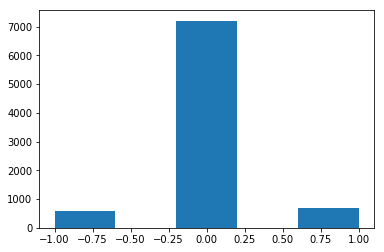

In [105]:
plt.hist(np.argmax(y_pred, axis=1)-np.argmax(y_val_VBF, axis=1), bins=5)